In [1]:
import sys
import numpy as np
import pandas as pd
import scipy.io as sio
import tensorflow as tf
import seaborn as sns
import statistics as stats
from numpy import argmax
from matplotlib import pyplot
from matplotlib import pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale 
from sklearn.preprocessing import PowerTransformer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

from sklearn.preprocessing import MinMaxScaler
from keras.layers import GRU,Bidirectional
from keras.layers import Flatten 
from keras.utils import to_categorical
from sklearn.preprocessing import PowerTransformer

#!pip install pydot
#!pip install graphviz # Need to install from outside
from tensorflow.keras.utils import plot_model

("Python version is", sys.version)
import sklearn
print("Scikit-learn version is: ", sklearn.__version__)
import tensorflow as tf
print("Tensorflow version is: ", tf.__version__)

import support_functions


/tmp/ipykernel_22362/2220173166.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-10 19:05:52.113562: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-10 19:05:52.239273: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-10 19:05:52.239366: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin

Scikit-learn version is:  1.4.0
Tensorflow version is:  2.15.0


In [2]:
# install if not installed
# !pip uninstall -y tensorflow
# !pip install --upgrade pip
# !pip install tensorflow
# !pip install sio

### Function to read and prepare the dataset

In [3]:
# Assumes dataset *.mat files in local directory
data_set_path = "AVP_D2_CPSR_train.mat"
df = support_functions.get_data(data_set_path)

No. of samples  1088
No. of features 71


### Explore dataset 

In [4]:
print("Shape of dataset = ",df.shape)
display(df.head(-5))
print(df.describe().T)  #Values need to be normalized before fitting. 
print(df.isnull().sum())
print(df.dtypes)
print(df['label'].value_counts())

Shape of dataset =  (1088, 72)


,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F63,F64,F65,F66,F67,F68,F69,F70,F71,label
0,10.0,0.0,1.0,7.0,0.0,0.0,0.0,3.0,1.0,4.0,...,6.0,2.0,0.0,17.0,0.0,2.0,6.0,13.0,-3.89,1.0
1,0.0,0.0,0.0,0.0,3.0,3.0,4.0,3.0,1.0,1.0,...,5.0,7.0,0.0,7.0,3.0,3.0,2.0,7.0,5.19,1.0
2,1.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,...,4.0,8.0,3.0,1.0,2.0,2.0,15.0,2.0,-4.08,1.0
3,1.0,0.0,3.0,1.0,0.0,0.0,0.0,3.0,3.0,4.0,...,8.0,7.0,0.0,10.0,0.0,2.0,16.0,8.0,-5.41,1.0
4,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,4.0,0.0,6.0,1.0,2.0,1.0,3.0,5.36,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1078,2.0,0.0,6.0,6.0,3.0,3.0,0.0,3.0,7.0,7.0,...,21.0,11.0,0.0,16.0,3.0,9.0,27.0,24.0,-17.55,0.0
1079,4.0,1.0,2.0,0.0,6.0,4.0,0.0,3.0,1.0,1.0,...,8.0,9.0,1.0,13.0,4.0,15.0,7.0,3.0,20.48,0.0
1080,3.0,1.0,2.0,1.0,1.0,0.0,2.0,2.0,0.0,4.0,...,8.0,3.0,1.0,9.0,0.0,4.0,8.0,6.0,4.69,0.0
1081,2.0,1.0,1.0,1.0,1.0,6.0,0.0,3.0,0.0,3.0,...,3.0,11.0,1.0,9.0,6.0,10.0,10.0,2.0,10.17,0.0


        count      mean       std    min     25%  50%      75%    max
F1     1088.0  2.229779  2.375232   0.00  1.0000  2.0   3.0000  16.00
F2     1088.0  0.970588  1.767294   0.00  0.0000  0.0   1.0000  16.00
F3     1088.0  1.143382  1.696263   0.00  0.0000  1.0   2.0000  16.00
F4     1088.0  1.721507  2.130217   0.00  0.0000  1.0   3.0000  17.00
F5     1088.0  1.113051  1.494268   0.00  0.0000  1.0   2.0000  13.00
...       ...       ...       ...    ...     ...  ...      ...    ...
F68    1088.0  3.843750  3.656281   0.00  2.0000  3.0   5.0000  38.00
F69    1088.0  7.477022  6.992928   0.00  3.0000  6.0  10.0000  66.00
F70    1088.0  7.241728  6.205424   0.00  4.0000  6.0  10.0000  71.00
F71    1088.0  0.416903  8.014201 -40.64 -3.6125  1.0   5.2225  78.13
label  1088.0  0.500000  0.500230   0.00  0.0000  0.5   1.0000   1.00

[72 rows x 8 columns]
F1       0
F2       0
F3       0
F4       0
F5       0
        ..
F68      0
F69      0
F70      0
F71      0
label    0
Length: 72, dtyp

In [5]:
# Define the dependent variable that needs to be predicted (labels)

y = df["label"].values

# Encoding categorical data
labelencoder = LabelEncoder()
Y = labelencoder.fit_transform(y) # 1 and 0
X = df.drop(labels = ["label"], axis=1)
display(Y)
display(X)

array([1, 1, 1, ..., 0, 0, 0])

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F62,F63,F64,F65,F66,F67,F68,F69,F70,F71
0,10.0,0.0,1.0,7.0,0.0,0.0,0.0,3.0,1.0,4.0,...,5.0,6.0,2.0,0.0,17.0,0.0,2.0,6.0,13.0,-3.89
1,0.0,0.0,0.0,0.0,3.0,3.0,4.0,3.0,1.0,1.0,...,3.0,5.0,7.0,0.0,7.0,3.0,3.0,2.0,7.0,5.19
2,1.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,...,5.0,4.0,8.0,3.0,1.0,2.0,2.0,15.0,2.0,-4.08
3,1.0,0.0,3.0,1.0,0.0,0.0,0.0,3.0,3.0,4.0,...,6.0,8.0,7.0,0.0,10.0,0.0,2.0,16.0,8.0,-5.41
4,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,4.0,0.0,6.0,1.0,2.0,1.0,3.0,5.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1083,0.0,0.0,2.0,1.0,2.0,1.0,1.0,0.0,4.0,1.0,...,4.0,4.0,4.0,0.0,4.0,1.0,3.0,4.0,8.0,-1.81
1084,2.0,1.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,2.0,...,3.0,3.0,4.0,1.0,5.0,1.0,4.0,4.0,5.0,-1.18
1085,4.0,2.0,3.0,5.0,3.0,8.0,3.0,6.0,5.0,8.0,...,19.0,14.0,19.0,2.0,24.0,8.0,12.0,25.0,21.0,-2.71
1086,9.0,4.0,13.0,6.0,2.0,3.0,0.0,4.0,7.0,2.0,...,20.0,13.0,10.0,4.0,19.0,3.0,13.0,23.0,35.0,-30.58


#### Check value distribution 

<class 'pandas.core.frame.DataFrame'>


/tmp/ipykernel_19548/4179827835.py:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X_Scaled, fill=True, alpha=.75, linewidth=0, multiple="stack", legend=False)


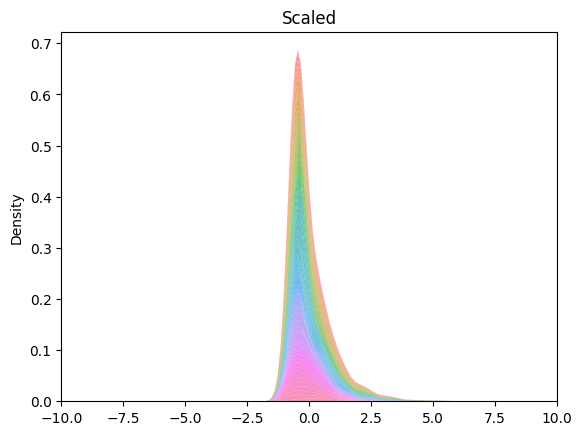

/tmp/ipykernel_19548/4179827835.py:14: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(Xpt, fill=True, alpha=.75, linewidth=0, multiple="stack", legend=False)


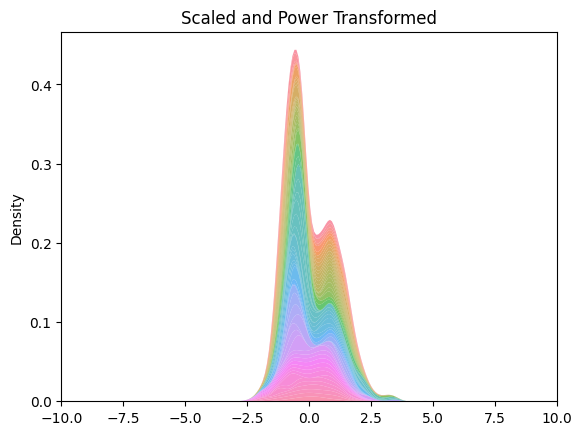

In [57]:
#sns.kdeplot(data=scale(X), fill=True, palette='viridis', alpha=.5, linewidth=0, legend=False)

print(type(X)) 

X_Scaled = scale(X)
pt = PowerTransformer(standardize=True)
Xpt = pt.fit_transform(X_Scaled)

sns.kdeplot(X_Scaled, fill=True, alpha=.75, linewidth=0, multiple="stack", legend=False)
plt.title('Scaled')
plt.xlim(-10,10)
plt.show();

sns.kdeplot(Xpt, fill=True, alpha=.75, linewidth=0, multiple="stack", legend=False)
plt.title('Scaled and Power Transformed')
plt.xlim(-10,10)
plt.show();



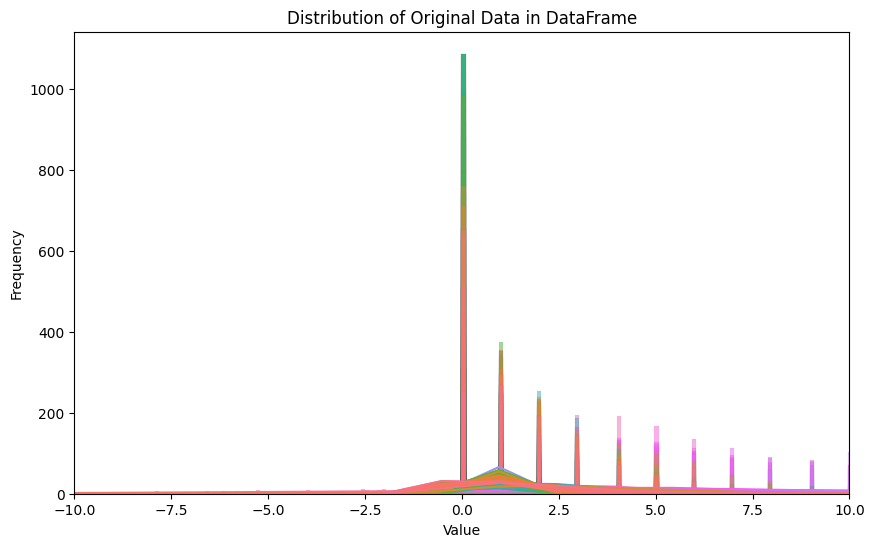

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = X.copy()

# Plotting using histplot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
sns.histplot(data=df, kde=True, legend=False)
plt.title('Distribution of Original Data in DataFrame')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xlim(-10,10)
plt.show()

### The architecture of the BiGRU

<img src="img/BiGRU.png" width=500 height=250 />

In [6]:
#
# Create the a BiGRU
#
def create_model():
    model = Sequential() 
    model.add(Bidirectional(GRU(8,return_sequences=True))) 
    model.add(Dropout(0.5)) 
    model.add(Bidirectional(GRU(4,return_sequences=True)))
    model.add(Dropout(0.5)) 
    model.add(Flatten()) 
    model.add(Dense(2, activation='sigmoid' ,name="Dense_2")) 
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics =['accuracy'])
    
    return model

In [7]:

# Define cross validation configuration
cv = KFold(n_splits=10, shuffle=True, random_state=42)

Fold_no = 1
acc_per_fold = [] #save accuracy from each fold

#LConvert our X from DataFrame to Numpy
X_array=X.to_numpy()


# Outside with statement intializes RUN_RESULTS.txt output file
# Writes the headers
# AT end of each FOLD convert all peromrance results to string and writes them to RUN_RESULTS.txt file

with open('RUN_RESULTS.txt', 'w') as cv_results:
    cv_results.write("Fold," + "Sen(%)," + "Spe(%)," + "ACC(%)," + "Pre(%)," + "Recall(%)," + "Auc(%)," + "F1(%)," + "\n")
    
    for train, test in cv.split(X_array, Y):
        print(f'Training for fold {Fold_no} ...')
        # get train and test data folds
        X_train, X_test = X_array[train], X_array[test]
        y_train, y_test = Y[train], Y[test]

        # For each split, apply scale and powertransform X_tarin and X_test data.
        # Scaling to make sure X data arrays of both train and test data values are of 
        # in same ranges, and since data is right skwed make it more like bell shape -- normalized
        
        X_train_scale = scale(X_train)
        X_test_scale  = scale(X_test)

        pt = PowerTransformer(standardize=True)
        Xp_train = pt.fit_transform(X_train_scale)
        Xp_test  = pt.fit_transform(X_test_scale)

        # Reshape X data arrays of both , make of rank 3 to file into the BiGRU neural network
        X_train_pt = np.reshape(Xp_train, (Xp_train.shape[0],Xp_train.shape[1],1))
        X_test_pt  = np.reshape(Xp_test, (Xp_test.shape[0],Xp_test.shape[1],1))
        
        # Convert the y_train and y_test like hot encodoing 0 1 where 0:negative class and 1 is positive class
        y_train = to_categorical(y_train)
        y_test  = to_categorical(y_test)

        # Intialize the BiGRU model, create compile 
        model2 = create_model()
        
        # Train teh model and save results and performance history
        history = model2.fit(X_train_pt, y_train, batch_size=32, verbose=0, epochs=100, validation_steps=5)
        print(history.history.keys())
        
        # save model trained on each fold using in the new keras format
        model2.save('models/model_fold_'+str(Fold_no)+'.keras')  
        
        # Evaluate the model by using teh test 
        scores = model2.evaluate(X_test_pt, y_test, verbose=0) # Evaluate the model - report accuracy and capture it into a list for future reporting
        acc_per_fold.append(scores[1] * 100)
        y_pred = model2.predict(X_test_pt)
        acc, pre,rec,F1,auc, se, sp = support_functions.calculate_model_performance(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
        
        # print('Sensitivity : {}'.format(round(se,3)))
        # print('Specifity : {}'.format(round(sp,3)))
        # print('accuracy : {}'.format(round(acc,3)))
        # print('Precision : {}'.format(round(pre,3)))
        # print('Recal : {}'.format(round(rec,3)))
        # print('Auc : {}'.format(round(auc,3)))
        # print('F1 : {}'.format(round(F1,3)))
    
        ResultsSummary = (str(round(se,3))  + "," + 
                          str(round(sp,3))  + "," + 
                          str(round(acc,3)) + "," + 
                          str(round(pre,3)) + "," +
                          str(round(rec,3)) + "," +
                          str(round(auc,3)) + "," +
                          str(round(F1,3 )) 
                         )
        cv_results.write(str(Fold_no) + "," + str(ResultsSummary + "\n"))
                
        Fold_no = Fold_no + 1

for acc in acc_per_fold:
    print("accuracy for this fold is: ", acc)


Training for fold 1 ...


2024-02-10 19:06:24.328184: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-10 19:06:24.328604: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


dict_keys(['loss', 'accuracy'])
4/4 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

     class 0       0.88      0.75      0.81        57
     class 1       0.77      0.88      0.82        52

    accuracy                           0.82       109
   macro avg       0.82      0.82      0.82       109
weighted avg       0.82      0.82      0.82       109


Confusion Matrix


,0,1
0,43,14
1,6,46


Training for fold 2 ...
dict_keys(['loss', 'accuracy'])
4/4 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

     class 0       0.76      0.91      0.83        45
     class 1       0.93      0.80      0.86        64

    accuracy                           0.84       109
   macro avg       0.84      0.85      0.84       109
weighted avg       0.86      0.84      0.85       109


Confusion Matrix


,0,1
0,41,4
1,13,51


Training for fold 3 ...
dict_keys(['loss', 'accuracy'])
4/4 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

     class 0       0.82      0.89      0.86        57
     class 1       0.87      0.79      0.83        52

    accuracy                           0.84       109
   macro avg       0.85      0.84      0.84       109
weighted avg       0.85      0.84      0.84       109


Confusion Matrix


,0,1
0,51,6
1,11,41


Training for fold 4 ...
dict_keys(['loss', 'accuracy'])
4/4 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

     class 0       0.87      0.78      0.82        50
     class 1       0.83      0.90      0.86        59

    accuracy                           0.84       109
   macro avg       0.85      0.84      0.84       109
weighted avg       0.85      0.84      0.84       109


Confusion Matrix


,0,1
0,39,11
1,6,53


Training for fold 5 ...
dict_keys(['loss', 'accuracy'])
4/4 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

     class 0       0.75      0.89      0.81        46
     class 1       0.91      0.78      0.84        63

    accuracy                           0.83       109
   macro avg       0.83      0.83      0.82       109
weighted avg       0.84      0.83      0.83       109


Confusion Matrix


,0,1
0,41,5
1,14,49


Training for fold 6 ...
dict_keys(['loss', 'accuracy'])
4/4 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

     class 0       0.80      0.90      0.85        52
     class 1       0.90      0.79      0.84        57

    accuracy                           0.84       109
   macro avg       0.85      0.85      0.84       109
weighted avg       0.85      0.84      0.84       109


Confusion Matrix


,0,1
0,47,5
1,12,45


Training for fold 7 ...
dict_keys(['loss', 'accuracy'])
4/4 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

     class 0       0.93      0.88      0.90        57
     class 1       0.87      0.92      0.90        52

    accuracy                           0.90       109
   macro avg       0.90      0.90      0.90       109
weighted avg       0.90      0.90      0.90       109


Confusion Matrix


,0,1
0,50,7
1,4,48


Training for fold 8 ...
dict_keys(['loss', 'accuracy'])
4/4 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

     class 0       0.84      0.82      0.83        62
     class 1       0.77      0.79      0.78        47

    accuracy                           0.81       109
   macro avg       0.80      0.80      0.80       109
weighted avg       0.81      0.81      0.81       109


Confusion Matrix


,0,1
0,51,11
1,10,37


Training for fold 9 ...
dict_keys(['loss', 'accuracy'])
4/4 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

     class 0       0.93      0.81      0.87        69
     class 1       0.73      0.90      0.80        39

    accuracy                           0.84       108
   macro avg       0.83      0.85      0.84       108
weighted avg       0.86      0.84      0.85       108


Confusion Matrix


,0,1
0,56,13
1,4,35


Training for fold 10 ...
dict_keys(['loss', 'accuracy'])
4/4 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

     class 0       0.81      0.90      0.85        49
     class 1       0.91      0.83      0.87        59

    accuracy                           0.86       108
   macro avg       0.86      0.86      0.86       108
weighted avg       0.87      0.86      0.86       108


Confusion Matrix


,0,1
0,44,5
1,10,49


accuracy for this fold is:  81.65137767791748
accuracy for this fold is:  84.40366983413696
accuracy for this fold is:  84.40366983413696
accuracy for this fold is:  84.40366983413696
accuracy for this fold is:  82.56880640983582
accuracy for this fold is:  84.40366983413696
accuracy for this fold is:  89.90825414657593
accuracy for this fold is:  80.73394298553467
accuracy for this fold is:  84.25925970077515
accuracy for this fold is:  86.11111044883728


In [8]:
print("mean = ",stats.mean(acc_per_fold))
print("std  = ",stats.stdev(acc_per_fold))

mean =  84.28474307060242
std  =  2.527711997563208


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_18 (Bidirect  (None, 71, 16)            528       
 ional)                                                          
                                                                 
 dropout_18 (Dropout)        (None, 71, 16)            0         
                                                                 
 bidirectional_19 (Bidirect  (None, 71, 8)             528       
 ional)                                                          
                                                                 
 dropout_19 (Dropout)        (None, 71, 8)             0         
                                                                 
 flatten_9 (Flatten)         (None, 568)               0         
                                                                 
 Dense_2 (Dense)             (None, 2)                

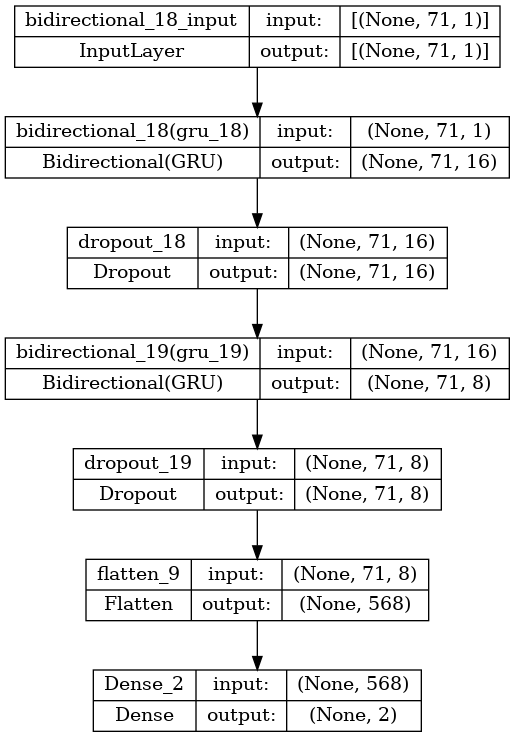

In [9]:
print(model2.summary())
print(history.history.keys())
plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

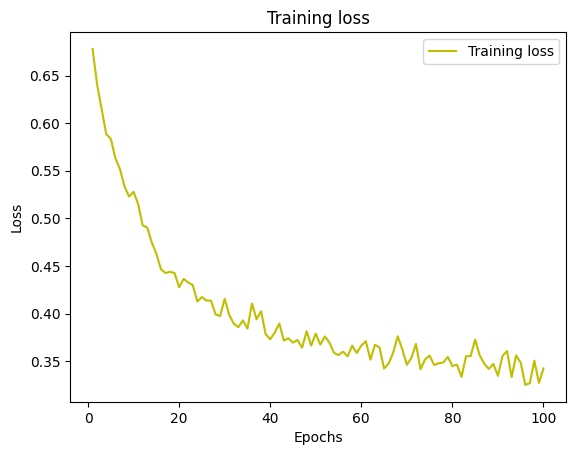

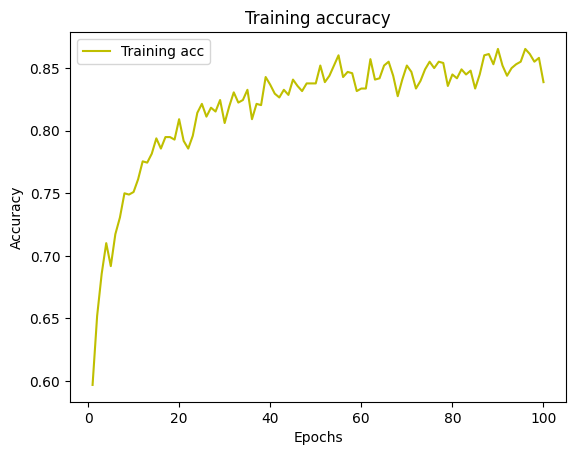

<Figure size 640x480 with 0 Axes>

In [10]:

# plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
# val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
#plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# plt.plot(history.history['accuracy']) 
# plt.plot(history.history['loss']) 

plt.tight_layout()


### Test best model from cross validation on independent dataset

In [12]:
data_test = sio.loadmat('AVP_D2_CPSR_test.mat')       # Read the MATLAB trainf dataset returns 
                                                      # a dictionary data structure 
data_test = data_test.get('AVP_D2_CPSR_test')         # Extract the training data array from dictionary
                                                      # data_test returnd is of numpy array with no headers nor labels
print("test data shape =", data_test.shape)     

# Build label vector (1's and 0's) 
label1_test = np.ones((60, 1))                       # Creat a vector of 60 elemnts all are 1's
label2_test = np.zeros((60, 1))                      # Create a vector of 60 elements all are 0's
label_test = np.append(label1_test, label2_test)     # Combine 0 and 1 vectors in one vector
label_test = np.array(label_test)                    # Make it numpy array
indepYtest = to_categorical(label_test)              # Do hot encoding 0 1 for each sample 

# Scale and normalize (bell shape distribution) the test dataset
indepxtest = scale(data_test)
pt = PowerTransformer(standardize=True)
indpXt = pt.fit_transform(indepxtest)

# reshape to fit as input to BiGRU neural network
indepXtest = np.reshape(indpXt, (indpXt.shape[0],indpXt.shape[1],1))
print("indepXtest after reshape =",indepXtest.shape)

# Load trained model
trained_model_path = 'models/model_fold_7.keras'

model7 = tf.keras.saving.load_model(trained_model_path)
print("Loaded model from location ", trained_model_path)

# Predicting the test set results
y_indp_pred = model7.predict(indepXtest)
print(indepXtest.shape)
print(y_indp_pred.shape)

test data shape = (120, 71)
indepXtest after reshape = (120, 71, 1)
Loaded model from location  models/model_fold_7.keras
4/4 [==============================] - 1s 11ms/step
(120, 71, 1)
(120, 2)


#### Calculate model's performance indicators
1. Print confusion matrix
2. plot the confusion matrix heatmap
3. Plot the ROC curve

              precision    recall  f1-score   support

     class 0       0.87      0.90      0.89        60
     class 1       0.90      0.87      0.88        60

    accuracy                           0.88       120
   macro avg       0.88      0.88      0.88       120
weighted avg       0.88      0.88      0.88       120


Confusion Matrix


,0,1
0,54,6
1,8,52


Sensitivity : 0.871
Specifity : 0.897
accuracy : 0.883
Precision : 0.897
Recal : 0.867
Auc : 0.883
F1 : 0.881


<AxesSubplot: >

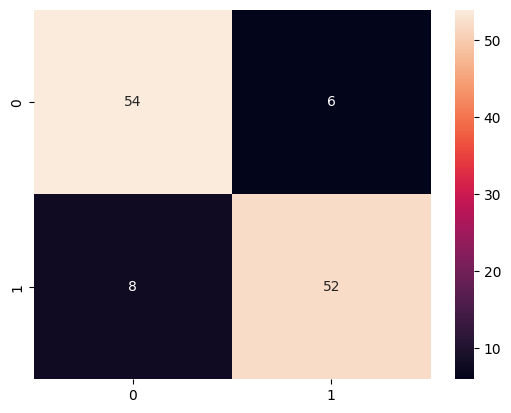

In [13]:

acc, pre,rec,F1,auc, se, sp = support_functions.calculate_model_performance(np.argmax(indepYtest, axis=1), np.argmax(y_indp_pred, axis=1))

print('Sensitivity : {}'.format(round(se,3)))
print('Specifity : {}'.format(round(sp,3)))
print('accuracy : {}'.format(round(acc,3)))
print('Precision : {}'.format(round(pre,3)))
print('Recal : {}'.format(round(rec,3)))
print('Auc : {}'.format(round(auc,3)))
print('F1 : {}'.format(round(F1,3)))

# Making the Confusion Matrix
cm = confusion_matrix(np.argmax(indepYtest, axis=1), np.argmax(y_indp_pred, axis=1))
sns.heatmap(cm, annot=True)



(120, 2)
(120,)


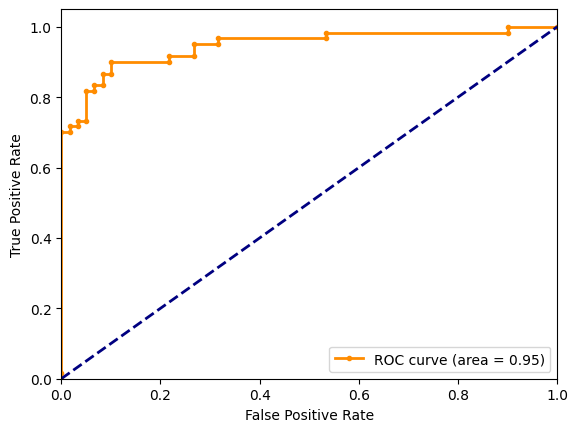

In [14]:
from sklearn.metrics import roc_auc_score

print(indepYtest.shape)
print(np.argmax(indepYtest, axis=1).shape)
# keep probabilities for the positive class predictions only
pos_model_probs = y_indp_pred[:, 1]

# Calculate ROC curve
fpr, tpr, _ = roc_curve(np.argmax(indepYtest, axis=1), pos_model_probs)
# Calculate AUC
roc_auc = roc_auc_score(np.argmax(indepYtest, axis=1), pos_model_probs)

plt.plot(fpr, tpr, marker='.',  color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # No skill mode curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate') # set axis labels
plt.ylabel('True Positive Rate')
plt.legend()                      # show the legend
plt.savefig("Test_ROC.jpg")       # Save plot
plt.show()                        # show the plot